In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the dataset with labels

Random Validation Images:


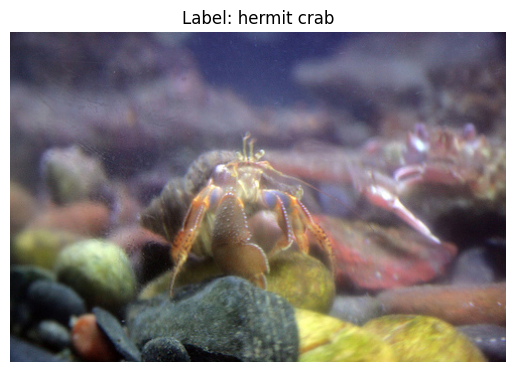

Random Training Images:


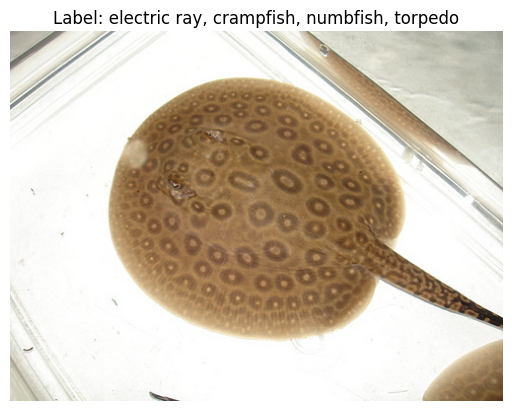

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 1)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 1)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Setting up Dataset and Dataloaders

In [3]:
# Creating the transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [5]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [6]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Setting up the Model

In [7]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!git clone https://github.com/dicarlolab/CORnet.git

Cloning into 'CORnet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 155 (delta 13), reused 9 (delta 8), pack-reused 135
Receiving objects: 100% (155/155), 68.11 KiB | 6.19 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [9]:
# Navigate to the cloned repository folder
import os
os.chdir('/kaggle/working/CORnet')

# Install the package if needed
!pip install .

Processing /kaggle/working/CORnet
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=3b1c0709be8bf9245db6cf5909e7d6efd1fbfe843b0aedd30b1a7888affc8e8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wh21_bu/wheels/ab/bb/f9/8716bf8cc3f23c0cd07d33b31c64ed0bc87023663d6be90ad5
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117031 sha256=ed1c06330c4018b743c405b95586c8cba643fe569cc99de0eedb833166900593
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built CORnet fire


In [10]:
# Import the CORnet-S model architecture
from cornet import cornet_s

# Initialize the CORnet-S model
model = cornet_s()

In [11]:
# Replace the final layer to match ImageNet100 classes
import torch.nn as nn

num_classes = 100
model.module.decoder.linear = nn.Linear(in_features=model.module.decoder.linear.in_features, out_features=num_classes)

In [12]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
model

DataParallel(
  (module): Sequential(
    (V1): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin2): ReLU(inplace=True)
      (output): Identity()
    )
    (V2): CORblock_S(
      (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (no

In [14]:
# Ensure CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import necessary modules
import time
from tqdm import tqdm

# Move model to the appropriate device
model = model.to(device)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Update running loss

        if i % 100 == 0:  # Print every 100 batches
            print(f"Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)  # Compute epoch loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)  # Compute epoch validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')

    # Save the model checkpoint
    model_save_path = f'/kaggle/working/cornet_s_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved at {model_save_path}')

print('Training complete')

CUDA available: True
Using device: cuda


Training Epoch 1/5:   0%|          | 1/4063 [00:02<3:16:16,  2.90s/it]

Step [0/4063], Loss: 4.8521


Training Epoch 1/5:   2%|▏         | 101/4063 [01:25<55:06,  1.20it/s]

Step [100/4063], Loss: 4.4334


Training Epoch 1/5:   5%|▍         | 201/4063 [02:49<54:08,  1.19it/s]  

Step [200/4063], Loss: 4.1998


Training Epoch 1/5:   7%|▋         | 301/4063 [04:16<56:49,  1.10it/s]  

Step [300/4063], Loss: 4.5458


Training Epoch 1/5:  10%|▉         | 401/4063 [05:44<53:30,  1.14it/s]

Step [400/4063], Loss: 4.2461


Training Epoch 1/5:  12%|█▏        | 501/4063 [07:11<51:51,  1.14it/s]

Step [500/4063], Loss: 4.0626


Training Epoch 1/5:  15%|█▍        | 601/4063 [08:40<50:40,  1.14it/s]

Step [600/4063], Loss: 4.1638


Training Epoch 1/5:  17%|█▋        | 701/4063 [10:13<51:14,  1.09it/s]

Step [700/4063], Loss: 4.0869


Training Epoch 1/5:  20%|█▉        | 801/4063 [11:42<48:03,  1.13it/s]

Step [800/4063], Loss: 3.9798


Training Epoch 1/5:  22%|██▏       | 901/4063 [13:11<48:26,  1.09it/s]

Step [900/4063], Loss: 4.3739


Training Epoch 1/5:  25%|██▍       | 1001/4063 [14:40<46:30,  1.10it/s]

Step [1000/4063], Loss: 3.9728


Training Epoch 1/5:  27%|██▋       | 1101/4063 [16:11<46:56,  1.05it/s]

Step [1100/4063], Loss: 3.9668


Training Epoch 1/5:  30%|██▉       | 1201/4063 [17:41<41:21,  1.15it/s]

Step [1200/4063], Loss: 3.9559


Training Epoch 1/5:  32%|███▏      | 1301/4063 [19:09<41:21,  1.11it/s]

Step [1300/4063], Loss: 4.0018


Training Epoch 1/5:  34%|███▍      | 1401/4063 [20:38<38:41,  1.15it/s]

Step [1400/4063], Loss: 3.8167


Training Epoch 1/5:  37%|███▋      | 1501/4063 [22:08<39:12,  1.09it/s]

Step [1500/4063], Loss: 3.7441


Training Epoch 1/5:  39%|███▉      | 1601/4063 [23:37<36:28,  1.12it/s]

Step [1600/4063], Loss: 3.8697


Training Epoch 1/5:  42%|████▏     | 1701/4063 [25:05<34:50,  1.13it/s]

Step [1700/4063], Loss: 3.4339


Training Epoch 1/5:  44%|████▍     | 1801/4063 [26:33<32:36,  1.16it/s]

Step [1800/4063], Loss: 3.8027


Training Epoch 1/5:  47%|████▋     | 1901/4063 [28:02<30:56,  1.16it/s]

Step [1900/4063], Loss: 3.3362


Training Epoch 1/5:  49%|████▉     | 2001/4063 [29:30<29:28,  1.17it/s]

Step [2000/4063], Loss: 3.6139


Training Epoch 1/5:  52%|█████▏    | 2101/4063 [31:00<29:28,  1.11it/s]

Step [2100/4063], Loss: 3.8296


Training Epoch 1/5:  54%|█████▍    | 2201/4063 [32:31<28:17,  1.10it/s]

Step [2200/4063], Loss: 3.8768


Training Epoch 1/5:  57%|█████▋    | 2301/4063 [33:59<26:22,  1.11it/s]

Step [2300/4063], Loss: 3.7779


Training Epoch 1/5:  59%|█████▉    | 2401/4063 [35:31<24:50,  1.12it/s]

Step [2400/4063], Loss: 3.9026


Training Epoch 1/5:  62%|██████▏   | 2501/4063 [37:01<23:15,  1.12it/s]

Step [2500/4063], Loss: 3.3211


Training Epoch 1/5:  64%|██████▍   | 2601/4063 [38:33<22:11,  1.10it/s]

Step [2600/4063], Loss: 4.0241


Training Epoch 1/5:  66%|██████▋   | 2701/4063 [40:05<20:43,  1.10it/s]

Step [2700/4063], Loss: 3.9118


Training Epoch 1/5:  69%|██████▉   | 2801/4063 [41:37<18:40,  1.13it/s]

Step [2800/4063], Loss: 3.2532


Training Epoch 1/5:  71%|███████▏  | 2901/4063 [43:09<18:57,  1.02it/s]

Step [2900/4063], Loss: 3.7755


Training Epoch 1/5:  74%|███████▍  | 3001/4063 [44:40<15:51,  1.12it/s]

Step [3000/4063], Loss: 3.7451


Training Epoch 1/5:  76%|███████▋  | 3101/4063 [46:11<15:01,  1.07it/s]

Step [3100/4063], Loss: 3.5577


Training Epoch 1/5:  79%|███████▉  | 3201/4063 [47:42<12:51,  1.12it/s]

Step [3200/4063], Loss: 3.3683


Training Epoch 1/5:  81%|████████  | 3301/4063 [49:12<11:58,  1.06it/s]

Step [3300/4063], Loss: 3.6461


Training Epoch 1/5:  84%|████████▎ | 3401/4063 [50:43<09:57,  1.11it/s]

Step [3400/4063], Loss: 3.4714


Training Epoch 1/5:  86%|████████▌ | 3501/4063 [52:20<09:02,  1.04it/s]

Step [3500/4063], Loss: 3.1835


Training Epoch 1/5:  89%|████████▊ | 3601/4063 [53:51<06:56,  1.11it/s]

Step [3600/4063], Loss: 3.2877


Training Epoch 1/5:  91%|█████████ | 3701/4063 [55:21<05:22,  1.12it/s]

Step [3700/4063], Loss: 2.9265


Training Epoch 1/5:  94%|█████████▎| 3801/4063 [56:50<03:47,  1.15it/s]

Step [3800/4063], Loss: 3.1793


Training Epoch 1/5:  96%|█████████▌| 3901/4063 [58:20<02:23,  1.13it/s]

Step [3900/4063], Loss: 3.4179


Training Epoch 1/5:  98%|█████████▊| 4001/4063 [59:49<00:56,  1.10it/s]

Step [4000/4063], Loss: 3.2812


Validation Epoch 1/5: 100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch [1/5] - Time: 3741.13s
Train Loss: 3.7658
Validation Loss: 3.4359
Top-1 Accuracy: 0.1850, Top-5 Accuracy: 0.4494
Model saved at /kaggle/working/cornet_s_epoch1.pth


Training Epoch 2/5:   0%|          | 1/4063 [00:00<45:22,  1.49it/s]

Step [0/4063], Loss: 3.3052


Training Epoch 2/5:   2%|▏         | 98/4063 [01:04<43:34,  1.52it/s]


KeyboardInterrupt: 

# Implementing and Evaluating PGD attacks

In [ ]:
!pip install torchattacks

In [ ]:
import torch
import torchattacks
from tqdm import tqdm

# Assuming model, test_loader, and device are already defined

# Initialize PGD attack
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40)

# Evaluate model under PGD attack
pgd_correct = 0
pgd_total = 0

model.eval()  # Set model to evaluation mode
for inputs, labels in tqdm(test_loader, desc="PGD Attack Evaluation"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = pgd_attack(inputs, labels)
    
    # Forward pass with adversarial examples
    outputs = model(adv_inputs)
    
    # Calculate accuracy
    _, predicted = outputs.max(1)
    pgd_correct += predicted.eq(labels).sum().item()
    pgd_total += labels.size(0)

# PGD Attack accuracy
pgd_acc = pgd_correct / pgd_total
print(f'PGD Attack Accuracy: {pgd_acc:.4f}')

# Implementing and Evaluating Carlini Wagner Attacks

In [ ]:
# Initialize CW attack
cw_attack = torchattacks.CW(model, c=1e-4, kappa=0, steps=1000, lr=0.01)

# Evaluate model under CW attack
cw_correct = 0
cw_total = 0

model.eval()  # Set model to evaluation mode
for inputs, labels in tqdm(test_loader, desc="CW Attack Evaluation"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = cw_attack(inputs, labels)
    
    # Forward pass with adversarial examples
    outputs = model(adv_inputs)
    
    # Calculate accuracy
    _, predicted = outputs.max(1)
    cw_correct += predicted.eq(labels).sum().item()
    cw_total += labels.size(0)

# CW Attack accuracy
cw_acc = cw_correct / cw_total
print(f'CW Attack Accuracy: {cw_acc:.4f}')